# 10. Seq2Seq : Encoder-Decoder

* key point는 encoder RNN의 hidden state를 decoder input parameter로 넘기는 것.

 그리고 이 과정이 용이하도록 hidden state size를 n x n 차원으로 맞춤

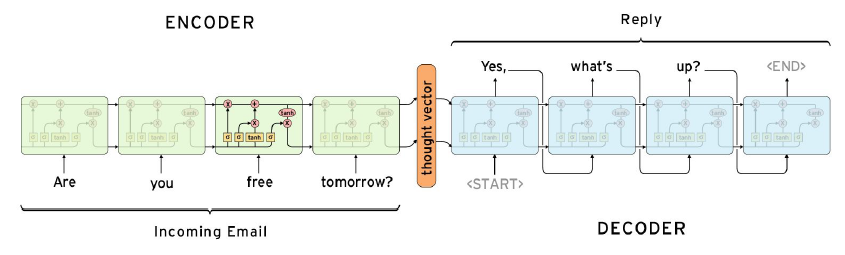

* Many to one, Timeseries 경우, 1회 RNN input에서 한 문장 또는 일련의 data tensor들이 한꺼번에 입력되는 것에 비해, Seq2Seq는 1회 RNN input에 한 문장을 구성하는 tensor list의 한개 원소씩 입력되며 RNN을 training 한다. 즉, 전자는 [[1], [2], [3], [4]]가 입력되나, 후자는 [1] 입력, [2] 입력, [3] 입력.... 따로따로 input 된다.

In [5]:
import random
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim

In [6]:
torch.manual_seed(0)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

## 10-1. 문장 Sample 만들기

In [7]:
#data_path = "../../Test_Samples/seq2seq_samples.txt"     # long Sample
data_path = "Test_Samples/seq2seq_samples_short.txt"    # short sample

Kor_Eng = open(data_path, 'r', encoding= 'utf-8' )

In [8]:
# sample file 확인
for line in Kor_Eng:
    print(line)

이 냄새는 시간이 좀 지나면 없어질 것입니다.	This aroma may dissipate after a short period of time.

벌써 세 번째 나오는데 처음인게 신기하네요.	It's unbelievable that it's our first, given that we have done 3 releases.

새 위원회가 이번 주에 첫 총회를 개최한다.	The new committee holds its first plenary session this week.

그렇게 해도 그는 무례가 되지 않는다.	It is no discourtesy with him to do so.  

그들은 허심탄회한 대화를 나누었다 	They talked candidly with each other.  



In [9]:
Kor_Eng = open(data_path, 'r', encoding= 'utf-8' )     # re-loading

# 문장 dataset 구성 원리 확인
pairs = []
for line in Kor_Eng:
    pairs.append([s for s in line.strip().lower().split("\t")])

pairs

[['이 냄새는 시간이 좀 지나면 없어질 것입니다.',
  'this aroma may dissipate after a short period of time.'],
 ['벌써 세 번째 나오는데 처음인게 신기하네요.',
  "it's unbelievable that it's our first, given that we have done 3 releases."],
 ['새 위원회가 이번 주에 첫 총회를 개최한다.',
  'the new committee holds its first plenary session this week.'],
 ['그렇게 해도 그는 무례가 되지 않는다.', 'it is no discourtesy with him to do so.'],
 ['그들은 허심탄회한 대화를 나누었다 ', 'they talked candidly with each other.']]

In [10]:
# fix token for "start of sentence" and "end of sentence"
SOS_token = 0
EOS_token = 1

## 10-2. 단어번호장 (Vocabulary set)  만드는 방법

In [11]:
# class for vocabulary related information of data
class Vocab:
    def __init__(self):
        self.vocab2index = {"<SOS>": SOS_token, "<EOS>": EOS_token}
        self.index2vocab = {SOS_token: "<SOS>", EOS_token: "<EOS>"}
        self.vocab_count = {}
        self.n_vocab = len(self.vocab2index)

    def add_vocab(self, sentence):
        for word in sentence.split(" "):
            if word not in self.vocab2index:
                self.vocab2index[word] = self.n_vocab       # 추가되는 단어 index 달기
                self.vocab_count[word] = 1                  
                self.index2vocab[self.n_vocab] = word       # 단어-index '역'-dict 생성
                self.n_vocab += 1                           # 사용된 총 단어 갯수
            else:
                self.vocab_count[word] += 1                 # 단어별 중복 사용 횟수 

In [12]:
# test 예제 문장 확인
print(pairs[2][0])
print(pairs[2][1])

새 위원회가 이번 주에 첫 총회를 개최한다.
the new committee holds its first plenary session this week.


In [13]:
# Vocab Class 작동 확인
testvoc = Vocab()
testvoc.add_vocab(pairs[2][0])
testvoc.add_vocab(pairs[2][1])
print('vocab2index :\n ', testvoc.vocab2index)
print('index2vocab :\n ', testvoc.index2vocab)
print('vocab_count:\n ', testvoc.vocab_count)
print('n_vocab :', testvoc.n_vocab)

vocab2index :
  {'<SOS>': 0, '<EOS>': 1, '새': 2, '위원회가': 3, '이번': 4, '주에': 5, '첫': 6, '총회를': 7, '개최한다.': 8, 'the': 9, 'new': 10, 'committee': 11, 'holds': 12, 'its': 13, 'first': 14, 'plenary': 15, 'session': 16, 'this': 17, 'week.': 18}
index2vocab :
  {0: '<SOS>', 1: '<EOS>', 2: '새', 3: '위원회가', 4: '이번', 5: '주에', 6: '첫', 7: '총회를', 8: '개최한다.', 9: 'the', 10: 'new', 11: 'committee', 12: 'holds', 13: 'its', 14: 'first', 15: 'plenary', 16: 'session', 17: 'this', 18: 'week.'}
vocab_count:
  {'새': 1, '위원회가': 1, '이번': 1, '주에': 1, '첫': 1, '총회를': 1, '개최한다.': 1, 'the': 1, 'new': 1, 'committee': 1, 'holds': 1, 'its': 1, 'first': 1, 'plenary': 1, 'session': 1, 'this': 1, 'week.': 1}
n_vocab : 19


## 10-3. 전처리 (preprocess)

* 문장을 읽으면서 단어마다 번호를 매기며 단어번호장(Vocab)을 만든다.

In [14]:
# filter out the long sentence from source and target data 
def filter_pair(pair, source_max_length, target_max_length):
    return len(pair[0].split(" ")) < source_max_length and len(pair[1].split(" ")) < target_max_length

In [15]:
# 긴 문장 제외 필터 작동 확인
filter_pair(pairs[2],10,10)                #한글, 영어 모두 10단어 미만인지 확인

False

In [16]:
# read and preprocess the corpus data
def preprocess(corpus, source_max_length, target_max_length):
    print("reading corpus...")
    pairs = []
    for line in corpus:                                                     # 단어장 만들기
        pairs.append([s for s in line.strip().lower().split("\t")])
    print("Read {} sentence pairs".format(len(pairs)))

    pairs = [pair for pair in pairs if filter_pair(pair, source_max_length, target_max_length)]
    print("Trimmed to {} sentence pairs".format(len(pairs)))                 # 긴문장 제외

    source_vocab = Vocab()
    target_vocab = Vocab()

    print("Counting words...")
    for pair in pairs:
        source_vocab.add_vocab(pair[0])                                      # Dataset 만들기
        target_vocab.add_vocab(pair[1])
    print("source vocab size =", source_vocab.n_vocab)
    print("target vocab size =", target_vocab.n_vocab)

    return pairs, source_vocab, target_vocab

In [17]:
# 전처리 테스트

Kor_Eng = open(data_path, 'r', encoding= 'utf-8' )     # re-loading

test_pairs, test_source_vocab, test_target_vocab = preprocess(Kor_Eng, source_max_length = 10, target_max_length = 12)
print(random.choice(test_pairs))

reading corpus...
Read 5 sentence pairs
Trimmed to 4 sentence pairs
Counting words...
source vocab size = 27
target vocab size = 35
['그렇게 해도 그는 무례가 되지 않는다.', 'it is no discourtesy with him to do so.']


In [18]:
# 전처리 결과 중, 문장 확인
test_pairs

[['이 냄새는 시간이 좀 지나면 없어질 것입니다.',
  'this aroma may dissipate after a short period of time.'],
 ['새 위원회가 이번 주에 첫 총회를 개최한다.',
  'the new committee holds its first plenary session this week.'],
 ['그렇게 해도 그는 무례가 되지 않는다.', 'it is no discourtesy with him to do so.'],
 ['그들은 허심탄회한 대화를 나누었다 ', 'they talked candidly with each other.']]

In [19]:
# 전처리 결과 중, Source Vocab 생성 확인    (target Vocab 생략)

print('1. vocab2index :\n ', test_source_vocab.vocab2index)
print('2. index2vocab :\n ', test_source_vocab.index2vocab)
print('3. vocab_count:\n ', test_source_vocab.vocab_count)
print('4. n_vocab :', test_source_vocab.n_vocab)

1. vocab2index :
  {'<SOS>': 0, '<EOS>': 1, '이': 2, '냄새는': 3, '시간이': 4, '좀': 5, '지나면': 6, '없어질': 7, '것입니다.': 8, '새': 9, '위원회가': 10, '이번': 11, '주에': 12, '첫': 13, '총회를': 14, '개최한다.': 15, '그렇게': 16, '해도': 17, '그는': 18, '무례가': 19, '되지': 20, '않는다.': 21, '그들은': 22, '허심탄회한': 23, '대화를': 24, '나누었다': 25, '': 26}
2. index2vocab :
  {0: '<SOS>', 1: '<EOS>', 2: '이', 3: '냄새는', 4: '시간이', 5: '좀', 6: '지나면', 7: '없어질', 8: '것입니다.', 9: '새', 10: '위원회가', 11: '이번', 12: '주에', 13: '첫', 14: '총회를', 15: '개최한다.', 16: '그렇게', 17: '해도', 18: '그는', 19: '무례가', 20: '되지', 21: '않는다.', 22: '그들은', 23: '허심탄회한', 24: '대화를', 25: '나누었다', 26: ''}
3. vocab_count:
  {'이': 1, '냄새는': 1, '시간이': 1, '좀': 1, '지나면': 1, '없어질': 1, '것입니다.': 1, '새': 1, '위원회가': 1, '이번': 1, '주에': 1, '첫': 1, '총회를': 1, '개최한다.': 1, '그렇게': 1, '해도': 1, '그는': 1, '무례가': 1, '되지': 1, '않는다.': 1, '그들은': 1, '허심탄회한': 1, '대화를': 1, '나누었다': 1, '': 1}
4. n_vocab : 27


## 10-4. tensorizing sentences

* 입력될 문장을 Vocab에 정리된 단어번호 List로 변환한다.

In [20]:
# convert sentence to the index tensor
def tensorize(vocab, sentence):
    indexes = [vocab.vocab2index[word] for word in sentence.split(" ")]
    indexes.append(vocab.vocab2index["<EOS>"])                     # 문장이 끝났음을 알리는 Token
    return torch.Tensor(indexes).long().to(device).view(-1, 1)   # view(-1,1)은 행렬 전치
                                              # RNN input은 3차원이므로 Embedding 결과가 3차원이 되기 위함                     

In [21]:
test_input_source = [tensorize(test_source_vocab, pair[0]) for pair in test_pairs]
test_input_source

[tensor([[2],
         [3],
         [4],
         [5],
         [6],
         [7],
         [8],
         [1]]),
 tensor([[ 9],
         [10],
         [11],
         [12],
         [13],
         [14],
         [15],
         [ 1]]),
 tensor([[16],
         [17],
         [18],
         [19],
         [20],
         [21],
         [ 1]]),
 tensor([[22],
         [23],
         [24],
         [25],
         [26],
         [ 1]])]

In [22]:
# 문장마다 길이가 달라도 padding 처리 필요없음
[len(leng) for leng in test_input_source]

[8, 8, 7, 6]

In [23]:
test_input_target = [tensorize(test_target_vocab, pair[1]) for pair in test_pairs]
test_input_target

[tensor([[ 2],
         [ 3],
         [ 4],
         [ 5],
         [ 6],
         [ 7],
         [ 8],
         [ 9],
         [10],
         [11],
         [ 1]]),
 tensor([[12],
         [13],
         [14],
         [15],
         [16],
         [17],
         [18],
         [19],
         [ 2],
         [20],
         [ 1]]),
 tensor([[21],
         [22],
         [23],
         [24],
         [25],
         [26],
         [27],
         [28],
         [29],
         [ 1]]),
 tensor([[30],
         [31],
         [32],
         [25],
         [33],
         [34],
         [ 1]])]

## 10-5. Reviewing seq2seq. Model

### 10-5-1. Embedding 정의

In [24]:
# embedding 정의
input_sen = test_input_source[1]          # test_input_source[0] 과 [1] 크기는 '8'로 같은데 IndexError 발생??
input_size = len(input_sen)+1                                  # '+1'은 (0:'<unk>')토큰을 크기에 포함
hidden_size = 10
test_embedding = nn.Embedding(input_size, hidden_size)

print(input_sen)

out = test_embedding(input_sen)      
out

tensor([[ 9],
        [10],
        [11],
        [12],
        [13],
        [14],
        [15],
        [ 1]])


IndexError: index out of range in self

* embedding Input size 주의

  -input 크기는 Vocab의 전체 단어 갯수이며, '0' 토큰이 포함되어야함.
   
   만약, embedding class 정의 후, (tensorized) input data 행렬 요소 값이 input 갯수를 넘으면,
   
   'index out of range in self' 오류 발생. 예) input size가 5인데 [6]이 입력되면 Error 발생함.
   
   단, input data의 차원에 유연함. 즉, ([1, 2, 3, 4]나 [[1], [2], [3], [4]] 입력 시, 차원은 달라도
   
   계산 결과는 동일함.

In [25]:
input_sen = test_input_source[3]              # 마지막에 EOS_token [1]이 포함되었음

In [26]:
input_size = max(input_sen) + 1                            # input_sen 요소 중, 최대값으로 input size
test_hidden_size = 5
test_enc_embedding = nn.Embedding(input_size, test_hidden_size)

print(input_sen)

enc_embedding_out = test_enc_embedding(input_sen[0])    # Training 할때, input_sen가 한꺼번에 입력되지 않고, 
                                                       # list로 하나씩 입력되므로, input_sen에 [0]을 추가했음.
print('embedding shape :', enc_embedding_out.shape)
enc_embedding_out

tensor([[22],
        [23],
        [24],
        [25],
        [26],
        [ 1]])
embedding shape : torch.Size([1, 5])


tensor([[ 0.9552,  1.2836,  1.3384, -0.2794, -0.5518]],
       grad_fn=<EmbeddingBackward>)

### 10-5-2. RNN 정의와 input 차원

In [27]:
print(enc_embedding_out.view(1, 1, -1).shape)           # RNN 입력을 위해서는 3차원 변경이 필요함.
enc_embedding_out.view(1, 1, -1)

torch.Size([1, 1, 5])


tensor([[[ 0.9552,  1.2836,  1.3384, -0.2794, -0.5518]]],
       grad_fn=<ViewBackward>)

In [28]:
# RNN input으로 들어갈 Hidden State 초기화 정의 ( embedding_out 처럼 3차원으로 만듬)
test_encoder_hidden = torch.zeros([1, 1, test_hidden_size])
test_encoder_hidden

tensor([[[0., 0., 0., 0., 0.]]])

In [29]:
# input RNN 정의
test_enc_gru = nn.GRU(test_hidden_size, test_hidden_size)

In [30]:
test_enc_gru(enc_embedding_out.view(1, 1, -1), test_encoder_hidden)    # .view(1, 1, -1) 없으면 차원 오류 발생

(tensor([[[ 0.2241,  0.1489,  0.2248, -0.0954,  0.0554]]],
        grad_fn=<StackBackward>),
 tensor([[[ 0.2241,  0.1489,  0.2248, -0.0954,  0.0554]]],
        grad_fn=<StackBackward>))

### 10-5-3. Encoding Model

* 앞서 확인한 embedding과 RNN을 하나의 class로 정리

In [31]:
# declare simple encoder
class Encoder(nn.Module):
    def __init__(self, input_size, hidden_size):
        super(Encoder, self).__init__()
        self.hidden_size = hidden_size
        self.embedding = nn.Embedding(input_size, hidden_size)
        self.gru = nn.GRU(hidden_size, hidden_size)

    def forward(self, x, hidden):
        x = self.embedding(x).view(1, 1, -1)        # RNN 입력을 위해서는 3차원 변경이 필요함.
        x, hidden = self.gru(x, hidden)
        return x, hidden

In [32]:
# encoder input 크기 확인
test_source_vocab.n_vocab

27

In [33]:
test_enc = Encoder(test_source_vocab.n_vocab, test_hidden_size)

In [34]:
# Test할 입력 문장 확인
test_source_tensor = input_sen
test_source_tensor

tensor([[22],
        [23],
        [24],
        [25],
        [26],
        [ 1]])

In [35]:
# Training 할때, input_sen가 한꺼번에 입력되지 않고, list로 하나씩 입력되는 방법

source_length = test_source_tensor.size(0)

for i in range(source_length):
    test_out, test_encoder_hidden = test_enc(test_source_tensor[i], test_encoder_hidden)
    print('test_source_tensor : ', test_source_tensor[i])
    print('test_out : ', test_out)
    print('test_encoder_hidden : ', test_encoder_hidden)

test_source_tensor :  tensor([22])
test_out :  tensor([[[ 0.5753, -0.3614, -0.1937,  0.0755,  0.4042]]],
       grad_fn=<StackBackward>)
test_encoder_hidden :  tensor([[[ 0.5753, -0.3614, -0.1937,  0.0755,  0.4042]]],
       grad_fn=<StackBackward>)
test_source_tensor :  tensor([23])
test_out :  tensor([[[-0.3833, -0.3877, -0.7296, -0.4788, -0.0394]]],
       grad_fn=<StackBackward>)
test_encoder_hidden :  tensor([[[-0.3833, -0.3877, -0.7296, -0.4788, -0.0394]]],
       grad_fn=<StackBackward>)
test_source_tensor :  tensor([24])
test_out :  tensor([[[ 0.3770, -0.5647, -0.7664, -0.4257,  0.3170]]],
       grad_fn=<StackBackward>)
test_encoder_hidden :  tensor([[[ 0.3770, -0.5647, -0.7664, -0.4257,  0.3170]]],
       grad_fn=<StackBackward>)
test_source_tensor :  tensor([25])
test_out :  tensor([[[ 0.2406,  0.0270, -0.4643, -0.2599,  0.4684]]],
       grad_fn=<StackBackward>)
test_encoder_hidden :  tensor([[[ 0.2406,  0.0270, -0.4643, -0.2599,  0.4684]]],
       grad_fn=<StackBackward>)


* 위 Hidden state의 변화를 보면, input_sen 단어 하나씩 입력됨에 따라 값이 변하고, 이렇게 문장의 내용이 sequence로 반영된 최종 결과가 Decoder에 넘어가게 됨. 따라서 문장의 단어 구성 차이를 hidden state는 모두 표현할 수 있게 됨.

### 10-5-4. Decoder RNN output 처리

In [36]:
# out_embedding 정의 (encoder embedding과 유사)
output_sen = test_input_target[3]                    # 앞서 test_input_source[3]에 대응되는 output문장
output_size = max(output_sen) + 1                    # output_sen 요소 중, 최대값으로 output size
test_dec_embedding = nn.Embedding(output_size, test_hidden_size)         # test_hidden_size는 앞서 정의됨.

print(output_sen)

tensor([[30],
        [31],
        [32],
        [25],
        [33],
        [34],
        [ 1]])


In [37]:
# 단, decoder의 첫 입력 data는 encoder와 반대로, 'output_sen[0]'이 아니고 SOS_token [0]이 먼저임.
# decoder 첫 input은 문장을 시작하라는 신호, 입력된 문장을 분석한 hidden state에 대처하라는 신호로 볼수 있음.

test_decoder_input = torch.Tensor([[SOS_token]]).long()
print('SOS_token : ', test_decoder_input)                   # output_sen[i]의 1차원과 달리 2차원으로 정의됨.
                                                            # 이 때문에 SOS' token을 먼저 입력했을 때
dec_embedding_out = test_dec_embedding(test_decoder_input)  # 'ec_embedding_out이 3차원이 됨
print('out embedding shape :', dec_embedding_out.shape)
dec_embedding_out

SOS_token :  tensor([[0]])
out embedding shape : torch.Size([1, 1, 5])


tensor([[[0.4974, 0.2685, 1.4769, 0.3548, 1.6247]]],
       grad_fn=<EmbeddingBackward>)

In [38]:
# output RNN 정의
test_dec_gru = nn.GRU(test_hidden_size, test_hidden_size)

In [39]:
test_decoder_hidden = test_encoder_hidden
test_dec_gru_out, dec_gru_hidden = test_dec_gru(dec_embedding_out.view(1, 1, -1), test_decoder_hidden) 
 # .view(1, 1, -1)은 embedding_out 차원이 2차원이든 3차원이든 모두 3차원으로 통일시킴

test_dec_gru_out

tensor([[[-0.4089, -0.0285, -0.3772, -0.5746,  0.4297]]],
       grad_fn=<StackBackward>)

In [40]:
# out_put 문장을 만들기 위한 Multivariable Linear regression 정의
output_size = test_target_vocab.n_vocab
test_dec_out = nn.Linear(test_hidden_size, output_size)
test_out = test_dec_out(test_dec_gru_out[0])           #[0]은 cost 계산시 Label과 차원 맞추기 위함
test_out

tensor([[ 0.2896,  0.4618,  0.0862, -0.6308,  0.6133, -0.0639, -0.0049,  0.0362,
         -0.2816, -0.1865, -0.3130,  0.3838, -0.5791, -0.1958, -0.1677, -0.3799,
         -0.1432, -0.2781,  0.3168,  0.0959, -0.4033,  0.3568, -0.2196, -0.0216,
         -0.3967, -0.0848, -0.4426,  0.0016, -0.0555,  0.0859, -0.1155,  0.2299,
          0.5534, -0.4056, -0.0859]], grad_fn=<AddmmBackward>)

In [41]:
# Multi-class Classification 정의
softmax = nn.LogSoftmax(dim=1)

In [42]:
x_out = softmax(test_out)
x_out

tensor([[-3.2594, -3.0871, -3.4628, -4.1797, -2.9356, -3.6129, -3.5538, -3.5127,
         -3.8305, -3.7355, -3.8619, -3.1652, -4.1280, -3.7447, -3.7167, -3.9288,
         -3.6921, -3.8271, -3.2321, -3.4530, -3.9523, -3.1921, -3.7686, -3.5705,
         -3.9457, -3.6338, -3.9915, -3.5473, -3.6045, -3.4630, -3.6644, -3.3190,
         -2.9956, -3.9546, -3.6348]], grad_fn=<LogSoftmaxBackward>)

### 10-5-5. Decoding Model

* 앞서 확인한 embedding, RNN, Multi-class Classification을 하나의 class로 정리

In [43]:
# simple decoder
class Decoder(nn.Module):
    def __init__(self, hidden_size, output_size):
        super(Decoder, self).__init__()
        self.hidden_size = hidden_size
        self.embedding = nn.Embedding(output_size, hidden_size)
        self.gru = nn.GRU(hidden_size, hidden_size)
        self.out = nn.Linear(hidden_size, output_size)
        self.softmax = nn.LogSoftmax(dim=1)

    def forward(self, x, hidden):
        x = self.embedding(x).view(1, 1, -1)    # .view(1, 1, -1)은 embedding_out차원을 3차원 만듬
        x, hidden = self.gru(x, hidden)
        x = self.softmax(self.out(x[0]))
        return x, hidden

* Decoding class 작동 확인

In [44]:
# decoder output 크기 재확인
test_target_vocab.n_vocab

35

In [45]:
# Test할 출력 문장 재확인
test_target_tensor = test_input_target[3]   # output_sen
test_target_tensor

tensor([[30],
        [31],
        [32],
        [25],
        [33],
        [34],
        [ 1]])

In [46]:
# Decoding instance 생성
test_hidden_size = 5
test_dec = Decoder(test_hidden_size, test_target_vocab.n_vocab)

In [47]:
test_decoder_input = torch.Tensor([[SOS_token]]).long()
target_length = test_target_tensor.size(0)
test_decoder_hidden = test_encoder_hidden

In [48]:
for i in range(1, target_length + 1):
    test_decoder_output, test_decoder_hidden = test_dec(test_decoder_input, test_decoder_hidden)
    test_decoder_input = test_target_tensor[i-1]         # Token 첫 입력 후 출력 문장 단어 순차 입력
    
    if i % 3 == 0:
        print('test_decoder_output : ', test_decoder_output)
        print('test_decoder_hidden : ', test_decoder_hidden)
        print('test_target_tensor[i] : ', test_target_tensor[i])

test_decoder_output :  tensor([[-3.5377, -3.6307, -3.7313, -3.5635, -3.5132, -3.4671, -3.5575, -3.9940,
         -4.0393, -3.3033, -3.8022, -3.6676, -3.7311, -4.4690, -3.3284, -3.6335,
         -3.8010, -3.4284, -3.9353, -3.1399, -2.9411, -3.8077, -3.6906, -3.7521,
         -3.0833, -3.6324, -3.9115, -3.8218, -3.0731, -3.6724, -3.2001, -3.7175,
         -3.4818, -3.7539, -3.2670]], grad_fn=<LogSoftmaxBackward>)
test_decoder_hidden :  tensor([[[ 0.3646, -0.2500,  0.2726,  0.2736, -0.6629]]],
       grad_fn=<StackBackward>)
test_target_tensor[i] :  tensor([25])
test_decoder_output :  tensor([[-3.5760, -3.7093, -3.8609, -3.6188, -3.4730, -3.2822, -3.4582, -3.8415,
         -3.7988, -3.4978, -3.8804, -3.6556, -3.5878, -4.1148, -3.4163, -3.7124,
         -3.8774, -3.2348, -4.0414, -3.3041, -2.9846, -3.6039, -3.5750, -3.6765,
         -3.1766, -3.8608, -3.8674, -3.7416, -3.3479, -3.7234, -3.2353, -3.6130,
         -3.2546, -3.5838, -3.4157]], grad_fn=<LogSoftmaxBackward>)
test_decoder_hidden

## 10-6. Cost Function

In [49]:
# Decoder에서 Log Softmax를 사용했으므로, Cost 함수는 NLL 사용
criterion = nn.NLLLoss()
criterion(x_out, test_input_target[0][0])

tensor(3.4628, grad_fn=<NllLossBackward>)

In [50]:
# 또는 Decoder에서 softmax를 제거하고 Log Softmax와 NLL이 통합된 cross entropy 사용

import torch.nn.functional as F

test_out2 = test_dec_out(test_dec_gru_out)
F.cross_entropy(test_out2[0], test_input_target[0][0])     #[0]는 차원 맞추기

tensor(3.4628, grad_fn=<NllLossBackward>)

## 10-7. Training Coding

* 지금까지 Review한 내용들로 전체 Training Code 작성

In [51]:
# training seq2seq 정의

def train(pairs, source_vocab, target_vocab, encoder, decoder, n_iter, print_every=1000, learning_rate=0.01):
    loss_total = 0

    encoder_optimizer = optim.SGD(encoder.parameters(), lr=learning_rate)
    decoder_optimizer = optim.SGD(decoder.parameters(), lr=learning_rate)

    training_batch = [random.choice(pairs) for _ in range(n_iter)]
    training_source = [tensorize(source_vocab, pair[0]) for pair in training_batch]
    training_target = [tensorize(target_vocab, pair[1]) for pair in training_batch]

    criterion = nn.NLLLoss()

    for i in range(1, n_iter + 1):
        source_tensor = training_source[i - 1]
        target_tensor = training_target[i - 1]

        encoder_hidden = torch.zeros([1, 1, encoder.hidden_size]).to(device)

        encoder_optimizer.zero_grad()
        decoder_optimizer.zero_grad()

        source_length = source_tensor.size(0)
        target_length = target_tensor.size(0)

        loss = 0

        for enc_input in range(source_length):
            _, encoder_hidden = encoder(source_tensor[enc_input], encoder_hidden)

        decoder_input = torch.Tensor([[SOS_token]]).long().to(device)
        decoder_hidden = encoder_hidden           # connect encoder output to decoder input

        for di in range(target_length):
            decoder_output, decoder_hidden = decoder(decoder_input, decoder_hidden)
            loss += criterion(decoder_output, target_tensor[di])
            decoder_input = target_tensor[di]    # teacher forcing

        loss.backward()

        encoder_optimizer.step()
        decoder_optimizer.step()

        loss_iter = loss.item() / target_length
        loss_total += loss_iter

        if i % print_every == 0:
            loss_avg = loss_total / print_every
            loss_total = 0
            print("[{} - {}%] loss = {:05.4f}".format(i, i / n_iter * 100, loss_avg))

In [52]:
# declare max length for sentence
SOURCE_MAX_LENGTH = 10
TARGET_MAX_LENGTH = 12

In [53]:
# preprocess the corpus
Kor_Eng = open(data_path, 'r', encoding= 'utf-8' )

load_pairs, load_source_vocab, load_target_vocab = preprocess(Kor_Eng, SOURCE_MAX_LENGTH, TARGET_MAX_LENGTH)
print(random.choice(load_pairs))

reading corpus...
Read 5 sentence pairs
Trimmed to 4 sentence pairs
Counting words...
source vocab size = 27
target vocab size = 35
['그들은 허심탄회한 대화를 나누었다 ', 'they talked candidly with each other.']


In [54]:
# declare the encoder and the decoder
enc_hidden_size = 16
dec_hidden_size = enc_hidden_size
enc = Encoder(load_source_vocab.n_vocab, enc_hidden_size).to(device)
dec = Decoder(dec_hidden_size, load_target_vocab.n_vocab).to(device)

In [55]:
# train seq2seq model
train(load_pairs, load_source_vocab, load_target_vocab, enc, dec, 5000, print_every=1000)

[1000 - 20.0%] loss = 0.9837
[2000 - 40.0%] loss = 0.0796
[3000 - 60.0%] loss = 0.0326
[4000 - 80.0%] loss = 0.0202
[5000 - 100.0%] loss = 0.0146


## 10-8. Evaluation

In [56]:
# insert given sentence to check the training
def evaluate(pairs, source_vocab, target_vocab, encoder, decoder, target_max_length):
    for pair in pairs:
        print(">", pair[0])
        print("=", pair[1])
        source_tensor = tensorize(source_vocab, pair[0])
        source_length = source_tensor.size()[0]
        encoder_hidden = torch.zeros([1, 1, encoder.hidden_size]).to(device)

        for ei in range(source_length):
            _, encoder_hidden = encoder(source_tensor[ei], encoder_hidden)

        decoder_input = torch.Tensor([[SOS_token]], device=device).long()
        decoder_hidden = encoder_hidden
        decoded_words = []

        for di in range(target_max_length):
            decoder_output, decoder_hidden = decoder(decoder_input, decoder_hidden)
            _, top_index = decoder_output.data.topk(1)     # topk(1) : 상위 1번째까지 값과 그 index 출력
            if top_index.item() == EOS_token:             # 문장이 종료되는지 확인
                decoded_words.append("<EOS>")
                break
            else:
                decoded_words.append(target_vocab.index2vocab[top_index.item()])

            decoder_input = top_index.squeeze().detach()   # index값의 1차원 제거 및 연산추적 중단

        predict_words = decoded_words
        predict_sentence = " ".join(predict_words)
        print("<", predict_sentence)
        print("")

* Evaluation에서 Decoder output의 재입력

  -Training에서는 정답 단어를 입력했지만, Evaluation에서는 먼저 출력된 단어를 다시 입력시킴

In [57]:
test_decoder_output

tensor([[-3.4808, -3.7173, -3.7524, -3.5001, -3.5893, -3.4921, -3.6477, -3.8918,
         -3.9711, -3.3330, -3.7429, -3.5283, -3.7035, -4.3848, -3.3684, -3.6706,
         -3.8001, -3.3053, -3.9434, -3.2417, -3.0062, -3.8421, -3.5469, -3.7765,
         -3.0650, -3.6586, -3.8251, -3.8389, -3.1766, -3.6288, -3.1219, -3.7135,
         -3.3704, -3.7887, -3.4271]], grad_fn=<LogSoftmaxBackward>)

In [58]:
test_decoder_output.data.topk(1) 

torch.return_types.topk(
values=tensor([[-3.0062]]),
indices=tensor([[20]]))

In [59]:
_, test_index = test_decoder_output.data.topk(1) 
test_index

tensor([[20]])

In [60]:
test_index.squeeze()    # 차원이 1인 [[]]를 모두 제거함

tensor(20)

In [61]:
# test_dec에 재입력 Test
test_dec(test_index.squeeze(), test_decoder_hidden)         # .squeeze() 사용여부 상관없이 동일한 output 나옴

(tensor([[-3.4583, -3.6116, -3.8745, -3.5713, -3.5402, -3.3284, -3.5969, -3.9017,
          -3.9250, -3.4506, -3.7990, -3.5874, -3.6406, -4.2600, -3.4605, -3.7249,
          -3.7342, -3.2785, -4.0666, -3.2024, -2.9387, -3.8118, -3.5788, -3.8657,
          -3.0781, -3.7797, -3.9049, -3.8530, -3.3093, -3.7415, -3.1369, -3.6127,
          -3.2494, -3.6393, -3.3962]], grad_fn=<LogSoftmaxBackward>),
 tensor([[[ 0.4253, -0.3141,  0.0144,  0.0690, -0.6068]]],
        grad_fn=<StackBackward>))

In [62]:
test_index.squeeze().detach()    # 출력된 값을 다시 입력하면서 과 메모리를 사용하는 것을 방지하기 위해
                                 # Tensor 연산 기록을 추적하는 것을 중단시킴

tensor(20)

In [63]:
# check the model with given data
evaluate(load_pairs, load_source_vocab, load_target_vocab, enc, dec, TARGET_MAX_LENGTH)

> 이 냄새는 시간이 좀 지나면 없어질 것입니다.
= this aroma may dissipate after a short period of time.
< this aroma may dissipate after a short period of time. <EOS>

> 새 위원회가 이번 주에 첫 총회를 개최한다.
= the new committee holds its first plenary session this week.
< the new committee holds its first plenary session this week. <EOS>

> 그렇게 해도 그는 무례가 되지 않는다.
= it is no discourtesy with him to do so.
< it is no discourtesy with him to do so. <EOS>

> 그들은 허심탄회한 대화를 나누었다 
= they talked candidly with each other.
< they talked candidly with each other. <EOS>



* Reference

  https://www.edwith.org/boostcourse-dl-pytorch/lecture/43778/